In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the data
calories_hour_file = '/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv'
sleep_file = '/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv'

minute_sleep_data = pd.read_csv(sleep_file)
minute_calories_data = pd.read_csv(calories_hour_file)


In [87]:
# Convert timestamps to datetime, allowing pandas to infer the format
minute_sleep_data['date'] = pd.to_datetime(minute_sleep_data['date'], infer_datetime_format=True, errors='coerce')
minute_calories_data['ActivityMinute'] = pd.to_datetime(minute_calories_data['ActivityMinute'], infer_datetime_format=True, errors='coerce')

# Check for NaT values after conversion
print("Number of NaT values in ActivityMinute after inference:", minute_calories_data['ActivityMinute'].isna().sum())
print("Number of NaT values in date after inference:", minute_sleep_data['date'].isna().sum())


/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/2947971534.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  minute_sleep_data['date'] = pd.to_datetime(minute_sleep_data['date'], infer_datetime_format=True, errors='coerce')
/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/2947971534.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  minute_sleep_data['date'] = pd.to_datetime(minute_sleep_data['date'], infer_datetime_format=True, errors='coerce')
/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/2947971534.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will 

Number of NaT values in ActivityMinute after inference: 0
Number of NaT values in date after inference: 0


In [89]:
# Aggregate sleep data to hourly level
minute_sleep_data['ActivityHour'] = minute_sleep_data['date'].dt.floor('H')
hourly_sleep_data = minute_sleep_data.groupby(['Id', 'ActivityHour'])['value'].sum().reset_index()
hourly_sleep_data.rename(columns={'value': 'SleepDuration'}, inplace=True)

/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/4027903870.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  minute_sleep_data['ActivityHour'] = minute_sleep_data['date'].dt.floor('H')


In [88]:
print(minute_calories_data.head(10))

           Id      ActivityMinute  Calories
0  1503960366 2024-12-01 00:00:00    0.7973
1  1503960366 2024-12-01 00:01:00    0.7973
2  1503960366 2024-12-01 00:02:00    0.7973
3  1503960366 2024-12-01 00:03:00    0.7973
4  1503960366 2024-12-01 00:04:00    0.7973
5  1503960366 2024-12-01 00:05:00    0.7973
6  1503960366 2024-12-01 00:06:00    0.7973
7  1503960366 2024-12-01 00:07:00    0.7973
8  1503960366 2024-12-01 00:08:00    0.7973
9  1503960366 2024-12-01 00:09:00    0.7973


In [90]:
# Aggregate calorie data to hourly level
minute_calories_data['ActivityHour'] = minute_calories_data['ActivityMinute'].dt.floor('H')
hourly_calories_data = minute_calories_data.groupby(['Id', 'ActivityHour'])['Calories'].sum().reset_index()

print(hourly_calories_data.head())

           Id        ActivityHour     Calories
0  1503960366 2024-12-01 00:00:00  1858.690028
1  1503960366 2024-12-01 01:00:00  1616.455088
2  1503960366 2024-12-01 02:00:00  1591.862997
3  1503960366 2024-12-01 03:00:00  1527.276547
4  1503960366 2024-12-01 04:00:00  1478.570667


/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/1049681126.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  minute_calories_data['ActivityHour'] = minute_calories_data['ActivityMinute'].dt.floor('H')


In [91]:
# Merge sleep and calories data on Id and ActivityHour
merged_data = pd.merge(hourly_sleep_data, hourly_calories_data, on=['Id', 'ActivityHour'], how='inner')


In [93]:

# Check if merged dataset is empty
if merged_data.empty:
    print("Merged dataset is empty. Please check the merge conditions or the data alignment.")
else:
    # Define features (X) and target (y)
    X = merged_data[['SleepDuration']]
    y = merged_data['Calories']

    # Add a constant to the feature set for statsmodels (required for intercept estimation)
    X_with_constant = sm.add_constant(X)

In [94]:
print(minute_sleep_data['date'].dtype)  # Should show 'datetime64[ns]'


datetime64[ns]


In [33]:
# Drop the 'ActivityHour' column if it already exists to avoid conflicts
if 'ActivityHour' in minute_sleep_data.columns:
    minute_sleep_data.drop(columns=['ActivityHour'], inplace=True)

In [34]:
# Aggregate sleep data to hourly level by rounding down the minute-level timestamp
minute_sleep_data['ActivityHour'] = minute_sleep_data['date'].dt.floor('H')

/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/3388869621.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  minute_sleep_data['ActivityHour'] = minute_sleep_data['date'].dt.floor('H')


In [35]:
# Group the sleep data by Id and ActivityHour and sum the values
hourly_sleep_data = minute_sleep_data.groupby(['Id', 'ActivityHour'])['value'].sum().reset_index()

In [36]:
# Rename the aggregated column to 'SleepDuration'
hourly_sleep_data.rename(columns={'value': 'SleepDuration'}, inplace=True)

In [95]:
# Confirm the new DataFrame
print(hourly_sleep_data.head())

           Id        ActivityHour  SleepDuration
0  1503960366 2024-12-01 00:00:00            129
1  1503960366 2024-12-01 01:00:00            468
2  1503960366 2024-12-01 02:00:00            924
3  1503960366 2024-12-01 03:00:00           1446
4  1503960366 2024-12-01 04:00:00           1464


In [96]:
print(hourly_calories_data.head())

           Id        ActivityHour     Calories
0  1503960366 2024-12-01 00:00:00  1858.690028
1  1503960366 2024-12-01 01:00:00  1616.455088
2  1503960366 2024-12-01 02:00:00  1591.862997
3  1503960366 2024-12-01 03:00:00  1527.276547
4  1503960366 2024-12-01 04:00:00  1478.570667


In [97]:

# Merge the data on Id and ActivityHour
merged_data = pd.merge(hourly_calories_data, hourly_sleep_data, on=['Id', 'ActivityHour'], how='inner')


In [98]:
# Ensure 'Id' is the same type in both datasets (e.g., string)
hourly_calories_data['Id'] = hourly_calories_data['Id'].astype(str)
hourly_sleep_data['Id'] = hourly_sleep_data['Id'].astype(str)


In [99]:
# Ensure that 'ActivityHour' is properly formatted in both datasets
hourly_calories_data['ActivityHour'] = pd.to_datetime(hourly_calories_data['ActivityHour']).dt.floor('H')
hourly_sleep_data['ActivityHour'] = pd.to_datetime(hourly_sleep_data['ActivityHour']).dt.floor('H')


/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/2589920125.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_calories_data['ActivityHour'] = pd.to_datetime(hourly_calories_data['ActivityHour']).dt.floor('H')
/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_30036/2589920125.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_sleep_data['ActivityHour'] = pd.to_datetime(hourly_sleep_data['ActivityHour']).dt.floor('H')


In [100]:
# Check for missing values
print(hourly_calories_data.isna().sum())
print(hourly_sleep_data.isna().sum())

# Drop rows with missing values in key columns
hourly_calories_data.dropna(subset=['Id', 'ActivityHour'], inplace=True)
hourly_sleep_data.dropna(subset=['Id', 'ActivityHour'], inplace=True)


Id              0
ActivityHour    0
Calories        0
dtype: int64
Id               0
ActivityHour     0
SleepDuration    0
dtype: int64


In [102]:
# Build the regression model
ols_model = sm.OLS(y, X_with_constant).fit()

In [104]:
# Predict on the dataset
y_pred_statsmodels = ols_model.predict(X_with_constant)


In [105]:
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred_statsmodels))
    mae = mean_absolute_error(y, y_pred_statsmodels)
    adjusted_r2 = ols_model.rsquared_adj

In [106]:
    # Output model metrics
    print("Model Summary:")
    print(ols_model.summary())

Model Summary:
                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     91.24
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           5.93e-19
Time:                        17:42:31   Log-Likelihood:                -2392.8
No. Observations:                 289   AIC:                             4790.
Df Residuals:                     287   BIC:                             4797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3108.0008     77

In [108]:
# Output specific metrics
print("\nAdjusted R²:", adjusted_r2)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Adjusted R²: 0.23858335006502895
Root Mean Squared Error (RMSE): 953.9765394770617
Mean Absolute Error (MAE): 689.9606659174169


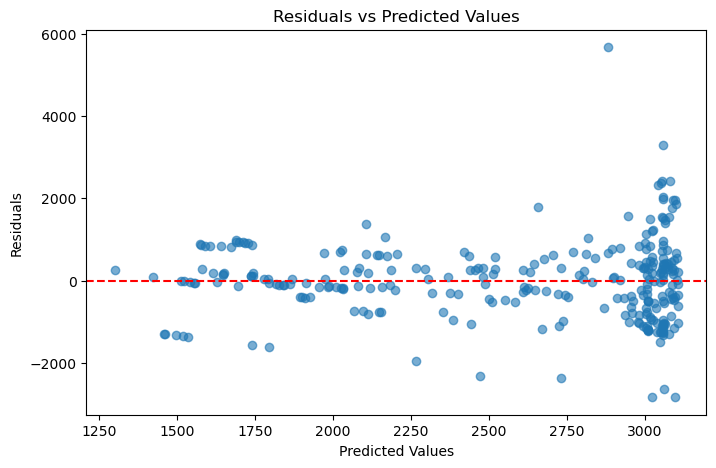

In [109]:
    # Plot residuals
    residuals = y - y_pred_statsmodels
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_statsmodels, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

Interpretations Based on the Metrics

*Model Performance Metrics*

Adjusted R²: 0.239
Adjusted R² measures the proportion of variability in the dependent variable (Calories burned) that is explained by the independent variable (Sleep Duration). Here, an Adjusted R² of 0.239 means that 23.9% of the variation in calories burned is explained by sleep duration. This indicates that while there is a relationship, it is not particularly strong, suggesting there are other factors contributing to calories burned beyond sleep duration.

Root Mean Squared Error (RMSE): 953.98
RMSE is a measure of how well the model’s predictions match the observed values, expressed in the same units as the dependent variable (Calories). An RMSE of 953.98 suggests that, on average, the difference between predicted and actual calorie values is about 953 calories. This is a relatively large error, which means that the model does not predict calories burned with high precision.

Mean Absolute Error (MAE): 689.96
MAE represents the average magnitude of errors in the model's predictions. Here, the MAE of 689.96 means that, on average, the model’s predictions are off by approximately 690 calories, which further suggests that there is significant variability not captured by sleep duration alone.


*Regression Coefficients and Statistical Significance*

Constant (Intercept): 3108.00
The constant or intercept indicates the predicted calories burned when sleep duration is zero. The value 3108.00 suggests that, on average, if sleep duration were zero, the model predicts about 3108 calories burned, which represents the baseline calorie expenditure possibly due to Basal Metabolic Rate (BMR) and other physiological processes.

Sleep Duration Coefficient: -0.8186
This coefficient represents the expected change in calories burned for each additional hour of sleep. The value of -0.8186 suggests a slight negative relationship between sleep duration and calories burned. For each additional minute of sleep, the calories burned decrease by approximately 0.8186. This negative relationship might be explained by reduced activity during longer sleep periods. However, the magnitude is quite small, indicating a weak impact.

P-value (Sleep Duration): 0.000
The p-value for Sleep Duration is 0.000, which is much less than the common significance level of 0.05. This means that the relationship between sleep duration and calories burned is statistically significant. In other words, there is strong evidence that sleep duration affects calories burned, although it might not be the most impactful variable.

*Statistical Tests*

F-statistic: 91.24, Prob (F-statistic): 5.93e-19
The F-statistic is used to test whether at least one independent variable is significantly related to the dependent variable. With an F-statistic of 91.24 and a p-value of 5.93e-19, the model is statistically significant overall, suggesting that the relationship between sleep duration and calories burned is unlikely to have occurred by chance.

Standard Error and t-statistics
The standard error for the Sleep Duration coefficient is 0.086, which is relatively small, indicating a reliable coefficient estimate.
The t-statistic of -9.552 for Sleep Duration shows that this variable is statistically significant, as the p-value for this t-statistic is well below 0.05.


*Resideual Diagnostics*

Omnibus: 60.468, Prob(Omnibus): 0.000
The Omnibus test is a test for normality in the residuals. With a probability value of 0.000, the residuals do not appear to be normally distributed, which could indicate some issues with model assumptions or a need for model improvements.

Jarque-Bera (JB): 271.280, Prob(JB): 1.24e-59
The Jarque-Bera test also indicates that the residuals deviate from normality (as evidenced by a very low p-value). This suggests that the model's errors are not normally distributed, potentially indicating model misspecification or the presence of outliers.

Durbin-Watson: 0.357
The Durbin-Watson statistic tests for the presence of autocorrelation in residuals. A value close to 2 indicates no autocorrelation. Here, the value of 0.357 suggests positive autocorrelation in the residuals, indicating that the errors are not independent. This could point to patterns over time that the model fails to capture.

*Condition Number and Multicollinearity*

Condition Number: 1.26e+03
The condition number is used to diagnose multicollinearity (when independent variables are highly correlated). A condition number above 30 indicates potential multicollinearity. With a condition number of 1260, this suggests that there may be some multicollinearity or numerical instability in the model. Since we only have one independent variable in this model, this high value might also indicate problems with scaling or variance in the data.

*Overall Interpretation and Recommendations*

Relationship Insight: The model indicates a weak but statistically significant negative relationship between sleep duration and calories burned. Although significant, the small coefficient indicates that sleep duration alone does not have a substantial impact on calorie expenditure.

Model Limitations: The low Adjusted R² suggests that a large proportion of the variation in calories burned is not explained by sleep duration. There are likely other important factors, such as physical activity, diet, or individual differences, that could provide a more complete understanding of calorie expenditure.

Residual Issues: The non-normality of residuals, the positive autocorrelation, and the high condition number all point to potential issues in the model. The errors are not independently distributed, which implies that there might be systematic trends that are not captured by this simple linear model. This might necessitate exploring other features or considering non-linear relationships.

*Conclusion*

The model demonstrates that there is a statistically significant relationship between sleep duration and calories burned, but this relationship is weak and does not fully explain the variability in the dependent variable. More comprehensive modeling approaches are required to better understand the factors influencing calorie expenditure, which likely include a mix of physical activity, dietary factors, and individual physiological differences.

The regression analysis indicates a statistically significant but weak negative relationship between sleep duration and calories burned, with sleep duration explaining only 23.9% of the variability in calorie expenditure. The model's low Adjusted R², high RMSE, and presence of non-normal residuals suggest that other factors, such as physical activity or diet, play a significant role in determining calorie expenditure beyond sleep duration alone. Furthermore, the positive autocorrelation in residuals implies that patterns in the data are not being fully captured by this simple linear model.